![image.png](attachment:image.png)

# 1. Introduction


### What is Captcha (Completely Automated Public Turing test to Tell Computers and Humans Apart)???  
According to Wikipedia, a CAPTCHA is a type of challenge–response test used in computing to determine whether or not the user is human.

### How does a CAPTCHA work?
The idea is that a computer program such as a bot will be unable to interpret the distorted letters, while a human being, who is used to seeing and interpreting letters in all kinds of contexts – different fonts, different handwritings, etc. – will usually be able to identify them.

**CAPTCHAs** were designed to prevent computers from automatically filling out forms by verifying that you are a real person. But with the rise of deep learning and computer vision, they can now often be defeated easily.

So after watching **Jeremy Howard** deeplearning course I decided to try something interesting and fun , so i choose this problem.

# 2. About Dataset
I am generating captcha images using this github repository - https://github.com/JackonYang/captcha-tensorflow

I have generated 5 digits captcha by just running this - 

```
    python3 datasets/gen_captcha.py -d --npi=5 -n 6
```

In [1]:
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
#path='../input/number-captcha/content/images/char-5-epoch-6/train'
path='/content/content/images/char-5-epoch-6/train'
test_path='/content/content/images/char-5-epoch-6/test'
fns = get_image_files(path)
fns_test= get_image_files(test_path)

In [3]:
len(fns),len(fns_test)

(181440, 30240)

In [7]:
fns[0]

PosixPath('/content/content/images/char-5-epoch-6/train/65214_4a035e4a-cb42-4ea1-bda9-874d5f6f93ff.png')

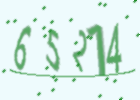

In [8]:
open_image(fns[0])

# 3. Data Preprocessing

### Function to get name of image(labels) from path

In [4]:
# Input: Path of image file
def get_image_name(fns):
  path=[]
  labels=[]
  for f in fns:
    f=str(f)
    path.append(f.strip('/'))
    labels.append("".join(f).split('/')[-1].split('.')[0].split('_')[0])
  return (labels)

In [5]:
labels=get_image_name(fns)

In [6]:
characters = set([letter for label in labels for letter in label])
characters=list(characters)
characters.sort()
print(len(characters), 'different characters were found')
print(characters)

10 different characters were found
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### Encoding dictionary

In [7]:
encoding_dict = {l:e for e,l in enumerate(characters)}
encoding_dict

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

### Decoding Dictionary

In [8]:
decoding_dict = {e:l for l,e in encoding_dict.items()}
decoding_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

### One-hot Encoding 

In [47]:
code_dimension=len(characters) #10=>0-9
captcha_dimension=5 # because we have 5 length captcha
def to_onehot(filename):
    code = str(filename).split('/')[-1].split('.')[0].split("_")[0]
    onehot = np.zeros((code_dimension, captcha_dimension))
    for column, letter in enumerate(code):
        onehot[encoding_dict[letter], column] = 1
    #print(onehot)
    return onehot.reshape(-1)

In [48]:
print("One-Hot Encoding for the captcha",labels[0])
to_onehot(fns[0])

One-Hot Encoding for the captcha 65214
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
test_data=ImageList.from_folder(test_path)
data=(ImageList.from_folder(path)
        .split_by_rand_pct(0.2,42)
        .label_from_func(to_onehot, label_cls = FloatList) #making it a regression instead of classification (because this gave better results)
        .transform(size=(96,256))
        .databunch(bs=64))
data.add_test(test_data)

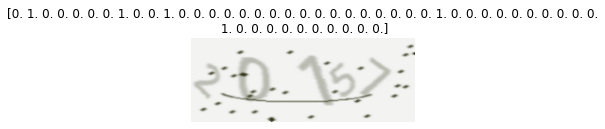

In [28]:
data.show_batch(rows=1)

**Now let's understand what above code does?**

The above code first taking all images from path specified and split the images to train/validation set (0.2 means 20% validation 80% train) and then adding labels from our specified function and then transforming images .After all that is specified we can create a DataBunch from the final output.
In fastai the data-containing object that we need to feed to a neural network is called a DataBunch. This is called a ‘bunch’ because it bunches together several PyTorch classes into one.

# 4. ResNet50(Residual Networks)

When Jeremy howard used ResNet-50 in first lecture , I have heard about it many times , but never used , but this time I was curious to know the underlying architecture behind it. So I started learning about it .

ResNet has been trained with 34, 50, 101 and 152 layers. And if that was not enough, with 1000 layers too!!

Before we understand the architecture of ResNet lets first understand about **vanishing gradient problem**


![image.png](attachment:image.png)

The gradient descent algorithm, in specific, updates the weights by the negative of the gradient multiplied by some small (between 0 and 1) scalar value.

As you can see, we are to “repeat” until convergence. In reality, though, we actually set a hyper-parameter for the number of max iterations. If the number of iterations is too small for certain deep neural nets, we will have inaccurate results. If the number is too large, the training duration will become infeasibly long. It’s an unsettling tradeoff between training time and accuracy.


For shallow network with only a few layers that use these activations, this isn’t a big problem. However, when more layers are used, it can cause the gradient to be too small for training to work effectively.(Approches to 0 )


![image.png](attachment:image.png)

When deeper networks are able to start converging, a  degradation problem has been exposed: with the network
depth increasing, accuracy gets saturated and then degrades rapidly. Unexpectedly,such degradation is not caused by overfitting, and adding
more layers to a suitably deep model leads to higher training error,

**Solution** - Residual Neural Networks (ResNets)

**What are Residual Neural Networks ?**

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It has 3.8 x 10^9 Floating points operations.

* Take shallow network and add extra layers without losing accuracy 

The idea behind residual network is simple whenever we backpropagate through an operation, we have to use the chain rule and multiply, but what if we were to backpropagate through the identity function? Then the gradient would simply be multiplied by 1 and nothing would happen to it! This is the idea behind ResNet: it stacks these residual blocks together where we use an identity function to preserve the gradient.

![image.png](attachment:image.png)

mathematically ,

```H(x) = F(x) + x, where F(x) = W2*relu(W1*x+b1)+b2```

![image.png](attachment:image.png)

So, that's our architecture , now let's use it .

In [25]:
def decode(onehot):
    onehot = onehot.reshape(code_dimension, captcha_dimension)
    idx = np.argmax(onehot, axis=0)
    return [decoding_dict[i.item()] for i in idx]


# metrics are calculated based on the number of correctly detected CAPTCHAs as a whole (i.e. correct detection of all
# five individual digits in a given CAPTCHA)
                            
def captcha_accuracy(preds, actuals):
    pred = torch.unbind(preds)
    act = torch.unbind(actuals)
    
    valid = 0
    total = 0
    
    for left,right in zip(pred,act):
        total+=1
        p = decode(left)
        a = decode(right)
        if p==a: valid += 1
     
    #print(valid,total)
    return torch.tensor(valid/total).cuda()

In [33]:
captcha_model = cnn_learner(data, models.resnet50, model_dir='models',pretrained=False,path=Path(''),metrics=[captcha_accuracy],
                   ps=0.1)

In [32]:
lr_find(captcha_model)

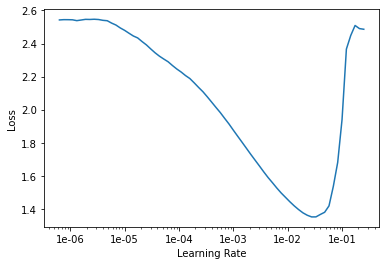

In [76]:
captcha_model.recorder.plot()

In [89]:
losses=captcha_model.recorder.losses
lrs=captcha_model.recorder.lrs
min_lr=lrs[np.argmin(losses)]
steep_lr=1e-4

In [90]:
min_lr/10,steep_lr

(0.002754228703338169, 0.0001)

We can see on this plot that in the range 1e-6 to 1e-5, nothing really happens and the model doesn't train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don't want a learning rate greater than point where it started increasing again as it will give a training that diverges like the one before, 

we can choose learning rate between min_lr/10 and steep_lr , so I choose 2e-03

In [97]:
%%time
captcha_model.fit_one_cycle(10,max_lr=2e-03,wd=0.01)

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.002940,0.000402,0.995233,13:29
1,0.003144,0.001238,0.980131,13:32
2,0.003248,0.000716,0.993138,13:39
3,0.003082,0.000582,0.994020,13:37
4,0.002924,0.000674,0.988040,13:37
5,0.002805,0.000449,0.993993,13:36
6,0.002578,0.000200,0.999035,13:37
7,0.002485,0.000175,0.998898,13:37
8,0.002450,0.000142,0.999532,13:37
9,0.002429,0.000118,0.999614,13:37


CPU times: user 1h 23min 34s, sys: 44min 7s, total: 2h 7min 42s
Wall time: 2h 16min 4s


In [98]:
captcha_model.save('captcha_model_v1',return_path=True)

PosixPath('models/captcha_model_v1.pth')

In [99]:
captcha_model.save('/content/gdrive/MyDrive/captcha_model_v1',return_path=True)

PosixPath('/content/gdrive/MyDrive/captcha_model_v1.pth')

In [34]:
captcha_model.load('/content/gdrive/MyDrive/captcha_model_v1')

Learner(data=ImageDataBunch;

Train: LabelList (145152 items)
x: ImageList
Image (3, 96, 256),Image (3, 96, 256),Image (3, 96, 256),Image (3, 96, 256),Image (3, 96, 256)
y: FloatList
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.],[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Path: /content/content/images/char-5-epoch-6/train;


# 5.  Model Evaluation on Test Set

In [ ]:
# Creating test set labels 
labels_test=[]
for f in fns_test:
  labels_test.append(to_onehot(f))
labels_test=tensor(labels_test)

In [35]:
res = captcha_model.get_preds(DatasetType.Test)

### Test Set Accuracy

In [37]:
captcha_accuracy(res[0],labels_test)

tensor(0.9995, device='cuda:0')

###  Example 1

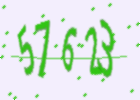

In [40]:
captcha_model.data.test_ds.x[1]

In [42]:
decode(res[0][1])

['5', '7', '6', '2', '3']

### Example 2

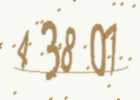

In [43]:
captcha_model.data.test_ds.x[50]

In [44]:
decode(res[0][50])

['4', '3', '8', '0', '7']

### Example 3

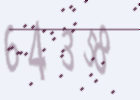

In [45]:
captcha_model.data.test_ds.x[240]

In [46]:
decode(res[0][240])

['6', '4', '3', '5', '8']

## References -

[1] https://arxiv.org/pdf/2006.08296.pdf

[2] https://github.com/JackonYang/captcha-tensorflow

[3] https://arxiv.org/abs/1512.03385
